Solve binary sudoku: 

| v0 | v1 |
-----------
| v2 | v3 |
-----------
where each row and column has no repeats


In [5]:
!pip install qiskit

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 301, in _get_abstract_dist_for
    skip_reason = self._check_skip_installed(req)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/legacy_resolve.py", line 253, in _check_skip_installed
    req_to_install.check_if_exists(self.use_user_site

In [4]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

ModuleNotFoundError: ignored

In [ ]:
NUM_QUBITS = 4

In [ ]:
def xor(qc, a, b, target):
  qc.cx(a, target)
  qc.cx(b, target)

def xor_board(qc):
  xor(qc, 0, 1, NUM_QUBITS)
  xor(qc, 0, 2, NUM_QUBITS + 1)
  xor(qc, 1, 3, NUM_QUBITS + 2)
  xor(qc, 2, 3, NUM_QUBITS + 3)

def oracle_mct(qc):
  qc.mct(list(range(NUM_QUBITS, NUM_QUBITS * 2)), NUM_QUBITS * 2)

def create_oracle():
  qc = QuantumCircuit((NUM_QUBITS * 2) + 1)
  xor_board(qc)
  oracle_mct(qc)

  criteria_qubit = NUM_QUBITS * 2
  qc.cz(criteria_qubit, 0)
  qc.cz(criteria_qubit, 1)
  
  # reset auxiliary qubits
  oracle_mct(qc)
  xor_board(qc)

  gate = qc.to_gate()
  gate.name = "oracle"

  return gate

In [ ]:
def diffuser_mct(qc, ctrls):
  qc.mct(ctrls, qc.num_qubits - 1)

def create_diffuser():
  qc = QuantumCircuit(NUM_QUBITS + 1)
  qubits = list(range(NUM_QUBITS))

  qc.h(qubits)
  qc.x(qubits)

  diffuser_mct(qc, qubits)
  qc.cz(NUM_QUBITS, 0)

  # reset aux qubit
  diffuser_mct(qc, qubits)

  qc.x(qubits)
  qc.h(qubits)
  
  gate = qc.to_gate()
  gate.name = "diffuser"
  return gate

diffuser = create_diffuser()

In [ ]:
grover_circ = QuantumCircuit((NUM_QUBITS * 2) + 2, NUM_QUBITS)

for i in range(NUM_QUBITS):
  grover_circ.h(i)

qubits = list(range(NUM_QUBITS))
oracle_qubits = qubits + list(range(NUM_QUBITS, (NUM_QUBITS * 2) + 1))
diffuser_qubits = qubits + [grover_circ.num_qubits - 1]
for i in range(2):
  grover_circ.append(oracle, oracle_qubits)
  grover_circ.append(diffuser, diffuser_qubits)

grover_circ.measure(qubits, qubits[ : : -1])
grover_circ.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─┐         
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├┤M├─────────
     ├───┤│         ││           ││         ││           │└╥┘┌─┐      
q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├─╫─┤M├──────
     ├───┤│         ││           ││         ││           │ ║ └╥┘┌─┐   
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├─╫──╫─┤M├───
     ├───┤│         ││           ││         ││           │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├─╫──╫──╫─┤M├
     └───┘│         ││           ││         ││           │ ║  ║  ║ └╥┘
q_4: ─────┤4 oracle ├┤           ├┤4 oracle ├┤           ├─╫──╫──╫──╫─
          │         ││  diffuser ││         ││  diffuser │ ║  ║  ║  ║ 
q_5: ─────┤5        ├┤           ├┤5        ├┤           ├─╫──╫──╫──╫─
          │         ││           ││         ││           │ ║  ║  ║  ║ 
q_6: ─────┤6        ├┤           ├┤6        ├┤           ├─╫──╫──╫──╫─
          │         ││           ││         ││           │ ║  ║  ║  ║ 
q_7: ─────┤7        ├┤           ├┤7        ├┤           ├─╫──╫──╫──╫─
          │         ││           ││         ││           │ ║  ║  ║  ║ 
q_8: ─────┤8        ├┤           ├┤8        ├┤           ├─╫──╫──╫──╫─
          └─────────┘│           │└─────────┘│           │ ║  ║  ║  ║ 
q_9: ────────────────┤4          ├───────────┤4          ├─╫──╫──╫──╫─
                     └───────────┘           └───────────┘ ║  ║  ║  ║ 
c: 4/══════════════════════════════════════════════════════╩══╩══╩══╩═
                                                           3  2  1  0

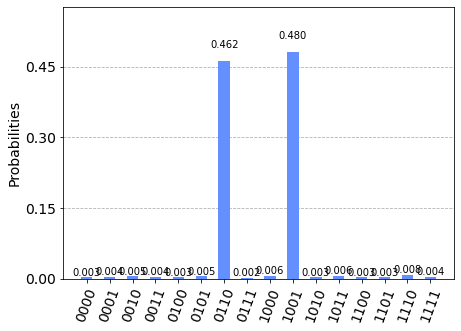

In [ ]:
backend = Aer.get_backend("qasm_simulator")
counts = execute(grover_circ, backend, shots = 1024).result().get_counts()
plot_histogram(counts)

In [ ]:
# try on real quantum computer

IBMQ.save_account("bbeb8005b8060940e0f37d88fd1f8c35ee3883c7c558e8c217bbd2ae97c348031548c16f5468063e5359d95038c69b3fbe85230b2fcc9df7a3c89d2a924738e2")
IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters = lambda x: x.configuration().n_qubits >= (NUM_QUBITS * 2) + 2 and 
                                      not x.configuration().simulator and x.status().operational == True))
print("least busy backend: ", backend)

configrc.store_credentials:WARNING:2021-04-12 18:13:41,090: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-04-12 18:13:41,461: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_16_melbourne


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Job Status: job has successfully run


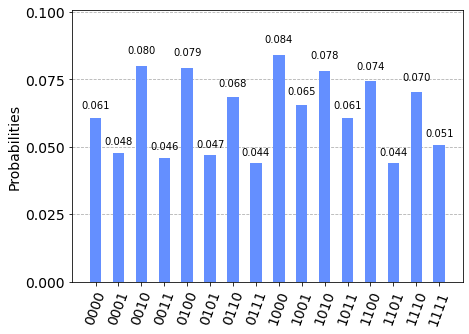

In [ ]:
transpiled = transpile(grover_circ, device, optimization_level = 3)
qobj = assemble(transpiled)
job = device.run(qobj)
job_monitor(job, interval = 2)
counts = job.result().get_counts(grover_circ)
plot_histogram(counts)